In [5]:
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm

from helpers.data_plot import *

In [6]:
df = pd.read_excel("./data/parent bedroom.xlsx")
df = df[df["datatype"] != "energy"].drop(columns = ["control"])
df.head(3)

,Unnamed: 0,epochtime,datatype,value,unit,min_value,max_value
0,0,2022-04-22 22:21:20,motion,1.000000,NaN,0.0,1.0
1,1,2022-04-22 22:22:30,power,22.723333,W,0.0,2500.0
2,2,2022-04-22 22:23:02,motion,0.000000,NaN,0.0,1.0


# 1. Thống nhất đơn vị dữ liệu

In [7]:
datatypes = df["datatype"].unique()
for datatype in datatypes:
    rows = df[df["datatype"] == datatype]
    units = rows["unit"].unique()
    print(f"{datatype}: {units}")

motion: [nan]
power: ['W']
acoustic: ['dBm']
CO2: ['ppm']
luminosity: ['Lux']
humidity: ['%']
temperature: ['Celcius']
contact: [nan]


In [8]:
def str2datetime(epochtime):
    return datetime.strptime(epochtime, '%Y-%m-%d %H:%M:%S')

df["epochtime"] = df["epochtime"].apply(str2datetime)
df.head(2)

,Unnamed: 0,epochtime,datatype,value,unit,min_value,max_value
0,0,2022-04-22 22:21:20,motion,1.000000,NaN,0.0,1.0
1,1,2022-04-22 22:22:30,power,22.723333,W,0.0,2500.0


# 2. Data Segmentation

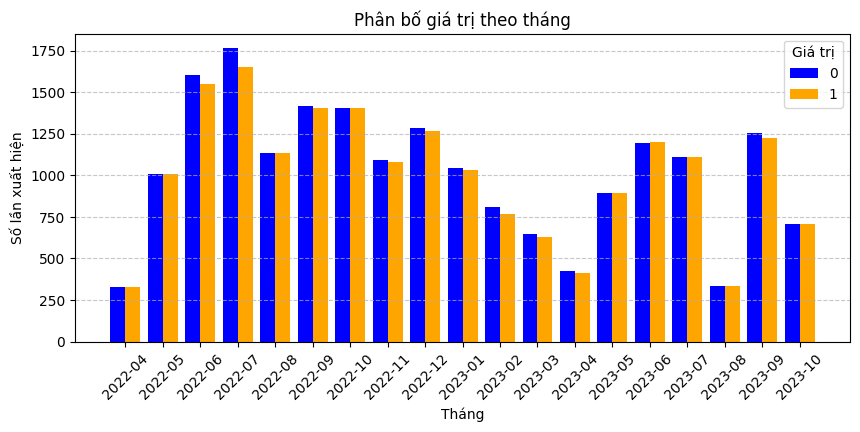

count    38592.000000
mean         0.495699
std          0.499988
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: value, dtype: float64


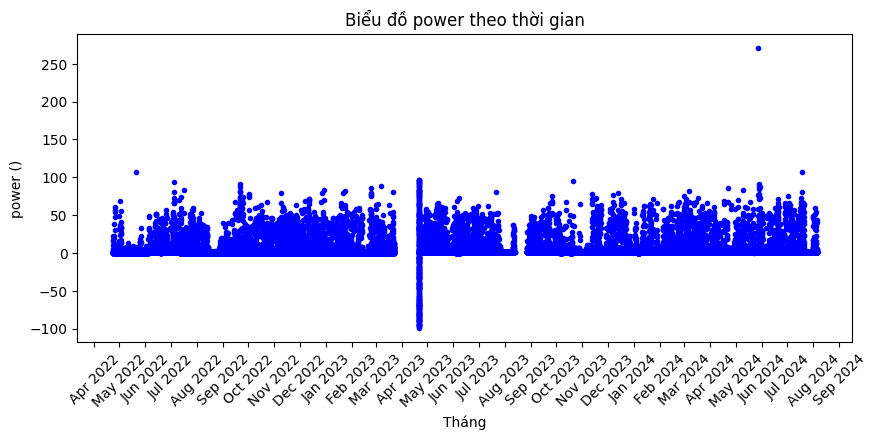

count    37660.000000
mean         4.007421
std         11.267651
min        -99.373574
25%          0.600000
50%          0.800000
75%          1.470000
max        270.680000
Name: value, dtype: float64


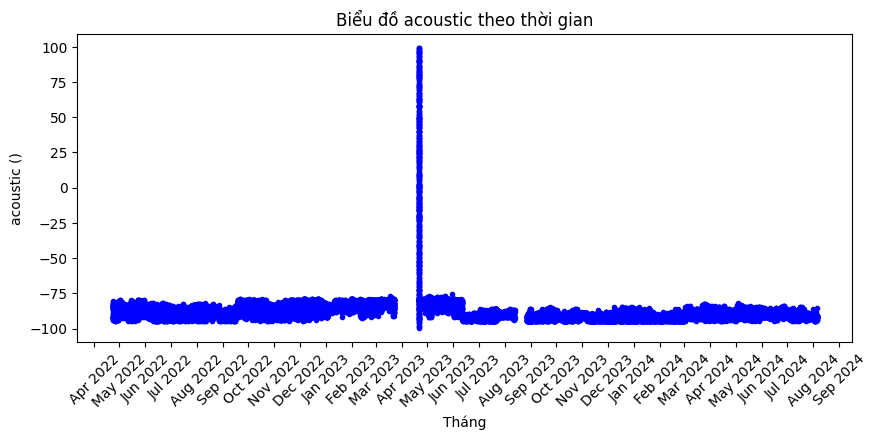

count    35195.000000
mean       -86.968861
std         12.772000
min        -99.671922
25%        -91.666667
50%        -89.000000
75%        -85.000000
max         99.000798
Name: value, dtype: float64


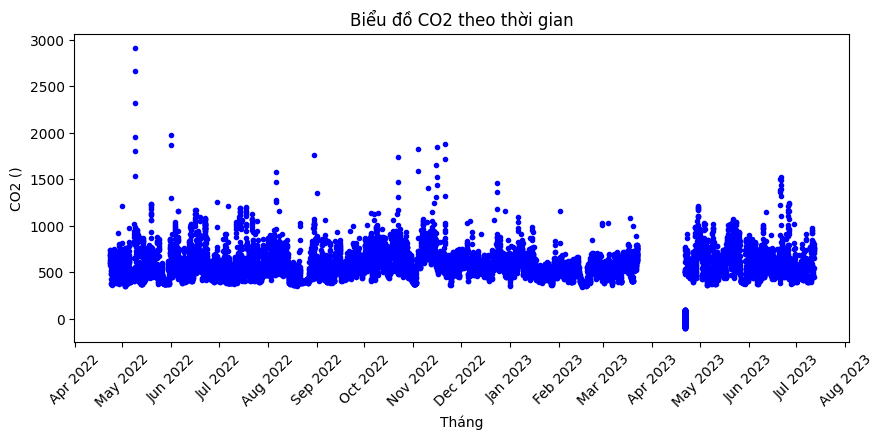

count    10433.000000
mean       578.959818
std        173.715085
min        -99.524293
25%        476.750000
50%        558.000000
75%        658.000000
max       2912.000000
Name: value, dtype: float64


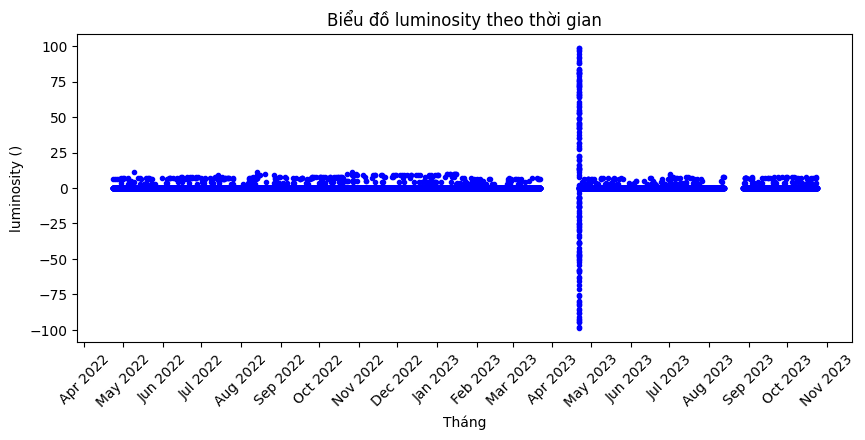

count    10054.000000
mean         0.401005
std          7.274986
min        -98.795461
25%          0.000000
50%          0.000000
75%          0.000000
max         98.646482
Name: value, dtype: float64


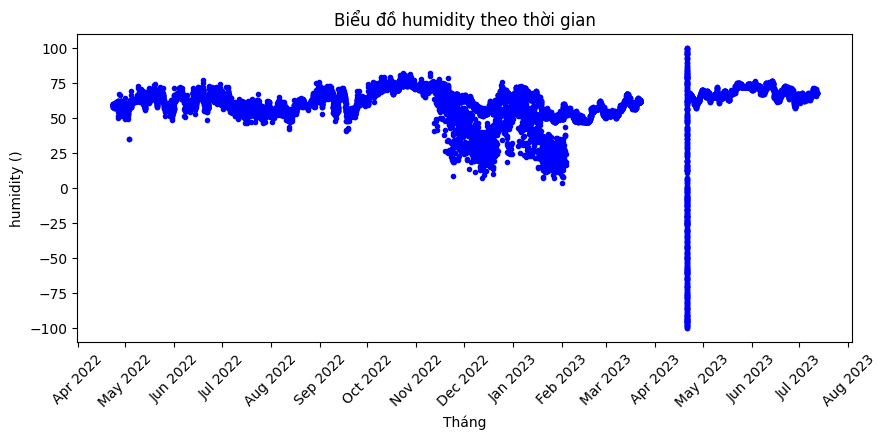

count    12925.000000
mean        58.002651
std         19.554783
min        -99.902750
25%         55.000000
50%         62.000000
75%         67.000000
max         99.778804
Name: value, dtype: float64


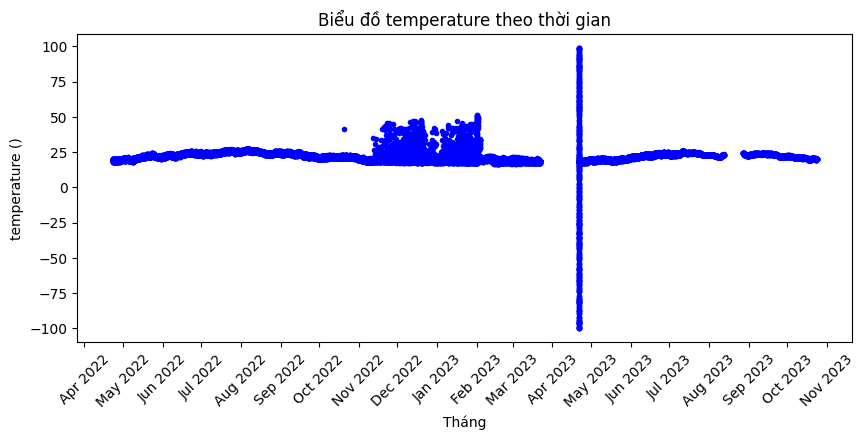

count    23136.000000
mean        21.347004
std          9.412589
min        -99.748757
25%         19.100000
50%         21.500000
75%         23.700000
max         98.718412
Name: value, dtype: float64


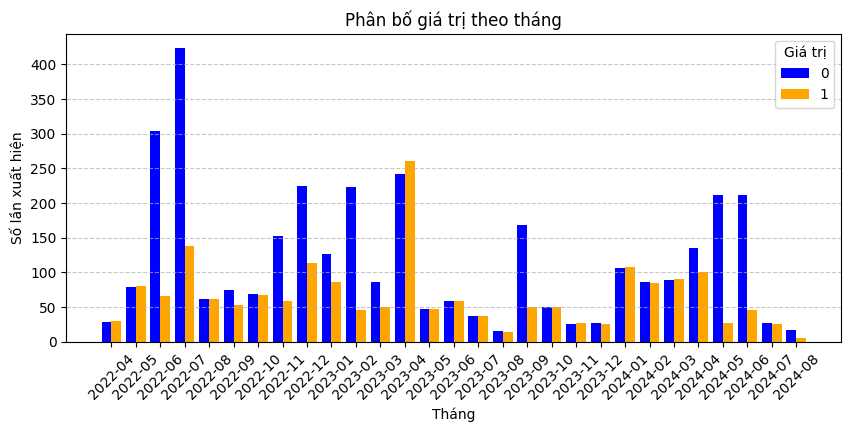

count    5307.000000
mean        0.359148
std         0.479796
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: value, dtype: float64


In [9]:
for datatype in datatypes:
    rows = df[df["datatype"] == datatype]

    if datatype not in {"motion", "contact"}:
        time, value = rows["epochtime"], rows["value"]
        lineplot(time, value, {"datatype": datatype, "unit": ""})
    
    else:
        barplot(rows["epochtime"], rows["value"])
    
    print(rows["value"].describe())

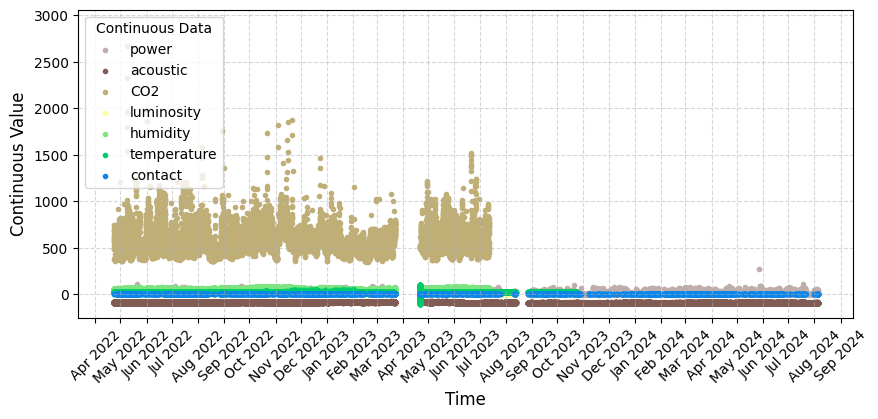

In [10]:
multi_scatterplot(df)

|Loại dữ liệu|Số mẫu dữ liệu|Thời gian bắt đầu|Thời gian kết thúc|
|------------|--------------|-----------------|------------------|
|`Motion`|38 592|4/2022|10/2023|
|`CO2`|10 433|4/2022|8/2023|
|`Luminosity`|10 054|4/2022|8/2023|
|`Temperature`|23 136|4/2022|8/2023|
|`Humidity`|12 925|4/2022|8/2023|
|`Acoustic`|35 195|4/2022|8/2024|
|`Power`|37 660|4/2022|8/2024|
|`Contact`|5 307|4/2022|8/2024|

- Khoảng thời gian đo dữ liệu của `Motion`, `CO2`, `Luminosity`, `Temperature`, `Humidity` chỉ được thu đến tháng 8 năm 2023, còn lại được thu đến tháng 8 năm 2024.
- Có 1 khoảng thời gian mà các các loại dữ liệu không được thu: `3/2023` - `5/2023`.

Vì vậy, tách dữ liệu thành 2 khoảng thời gian liên tục:
- `5/2022` - `2/2023`
- `6/2023` - `7/2023`

In [11]:
start_date = "2022-05-01"
end_date = "2023-07-31"

segment_df = df[
    (df["epochtime"] >= start_date) & 
    (df["epochtime"] <= end_date)
][["epochtime", "datatype", "value"]].reset_index(drop = True)

segment_df.head(2)

,epochtime,datatype,value
0,2022-05-01 00:01:40,acoustic,-86.666667
1,2022-05-01 00:11:40,acoustic,-86.000000


In [12]:
def avg_time_diff(df, plot = False):
    epochtimes = sorted(df["epochtime"].unique())

    time_diffs_min = []
    for i in range(len(epochtimes) - 1):
        interval = (epochtimes[i + 1] - epochtimes[i]).total_seconds() / 60
        if interval > 20000:
            print(f"Thời gian từ {epochtimes[i]} đến {epochtimes[i + 1]}: {interval / (60 * 24):.2f} ngày")
            continue

        time_diffs_min.append(interval)

    avg_interval = np.mean(time_diffs_min)

    print(f"Trung bình khoảng cách giữa các 2 lần đo dữ liệu: {avg_interval:.2f} phút")

    if plot:
        boxplot(pd.DataFrame(time_diffs_min, columns = ["Giữa 2 lần đo (phút)"]))

In [13]:
for datatype in datatypes:    
    print(f"{datatype}")
    avg_time_diff(segment_df[segment_df["datatype"] == datatype])
    print(f"----------------------------------------------")

motion
Thời gian từ 2023-03-22 12:51:53 đến 2023-04-21 09:53:10: 29.88 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 18.20 phút
----------------------------------------------
power
Thời gian từ 2023-03-22 13:45:00 đến 2023-04-21 09:53:10: 29.84 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 30.89 phút
----------------------------------------------
acoustic
Thời gian từ 2023-03-22 13:45:00 đến 2023-04-21 09:53:10: 29.84 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 30.31 phút
----------------------------------------------
CO2
Thời gian từ 2023-03-22 13:40:00 đến 2023-04-21 09:53:10: 29.84 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 57.29 phút
----------------------------------------------
luminosity
Thời gian từ 2023-03-22 13:15:00 đến 2023-04-21 09:53:10: 29.86 ngày
Trung bình khoảng cách giữa các 2 lần đo dữ liệu: 72.05 phút
----------------------------------------------
humidity
Thời gian từ 2023-03-22 13:40:00 đến 2023-04-21 09:53:10: 29.84 ngày


|Loại dữ liệu|Số mẫu dữ liệu|Thời gian bắt đầu|Thời gian kết thúc|Trung bình thời gian đo|
|------------|--------------|-----------------|------------------|-----------------------|
|`Motion`|38 592|4/2022|10/2023|18.19|
|`CO2`|10 433|4/2022|8/2023|31.01|
|`Luminosity`|10 054|4/2022|8/2023|30.33|
|`Temperature`|23 136|4/2022|8/2023|57.38|
|`Humidity`|12 925|4/2022|8/2023|72.12|
|`Acoustic`|35 195|4/2022|8/2024|47.93|
|`Power`|37 660|4/2022|8/2024|30.16|
|`Contact`|5 307|4/2022|8/2024|195.39|

- Thời gian đo trung bình đa số chạy từ 30 phút đến 80 phút, đặc biệt có dữ liệu `Contact` với 200 phút. Tuy nhiên, dữ liệu `Contact` dễ dàng nội suy do chỉ được thu khi có sự thay đổi.

Vì vậy, lấy timestamp = 1 giờ.

In [14]:
# - `4/2022` - `2/2023`
# - `6/2023` - `7/2023`

start_date = "2022-05-01"

first_start_gap = "2023-02-28"
first_end_gap = "2023-06-01"

end_date = "2023-07-31"

first_gap = pd.date_range(start = start_date, end = first_start_gap, freq = "60min")
second_gap = pd.date_range(start = first_end_gap, end = end_date, freq = "60min")

timestamps = first_gap.union(second_gap)
timestamps

DatetimeIndex(['2022-05-01 00:00:00', '2022-05-01 01:00:00',
               '2022-05-01 02:00:00', '2022-05-01 03:00:00',
               '2022-05-01 04:00:00', '2022-05-01 05:00:00',
               '2022-05-01 06:00:00', '2022-05-01 07:00:00',
               '2022-05-01 08:00:00', '2022-05-01 09:00:00',
               ...
               '2023-07-30 15:00:00', '2023-07-30 16:00:00',
               '2023-07-30 17:00:00', '2023-07-30 18:00:00',
               '2023-07-30 19:00:00', '2023-07-30 20:00:00',
               '2023-07-30 21:00:00', '2023-07-30 22:00:00',
               '2023-07-30 23:00:00', '2023-07-31 00:00:00'],
              dtype='datetime64[ns]', length=8714, freq=None)

In [15]:
segmented_data = []
cnt = 0
for i in tqdm(range(len(timestamps) - 1)):
    start = timestamps[i]
    end = timestamps[i + 1]

    segment = segment_df[
        (segment_df["epochtime"] >= start) &
        (segment_df["epochtime"] < end)
    ]

    if segment.empty:
        cnt += 1
  
    segmented_data.append(segment)

print(f"Có {cnt} khoảng thời gian không có dữ liệu!")

100%|██████████| 8713/8713 [00:06<00:00, 1412.96it/s]

Có 0 khoảng thời gian không có dữ liệu!


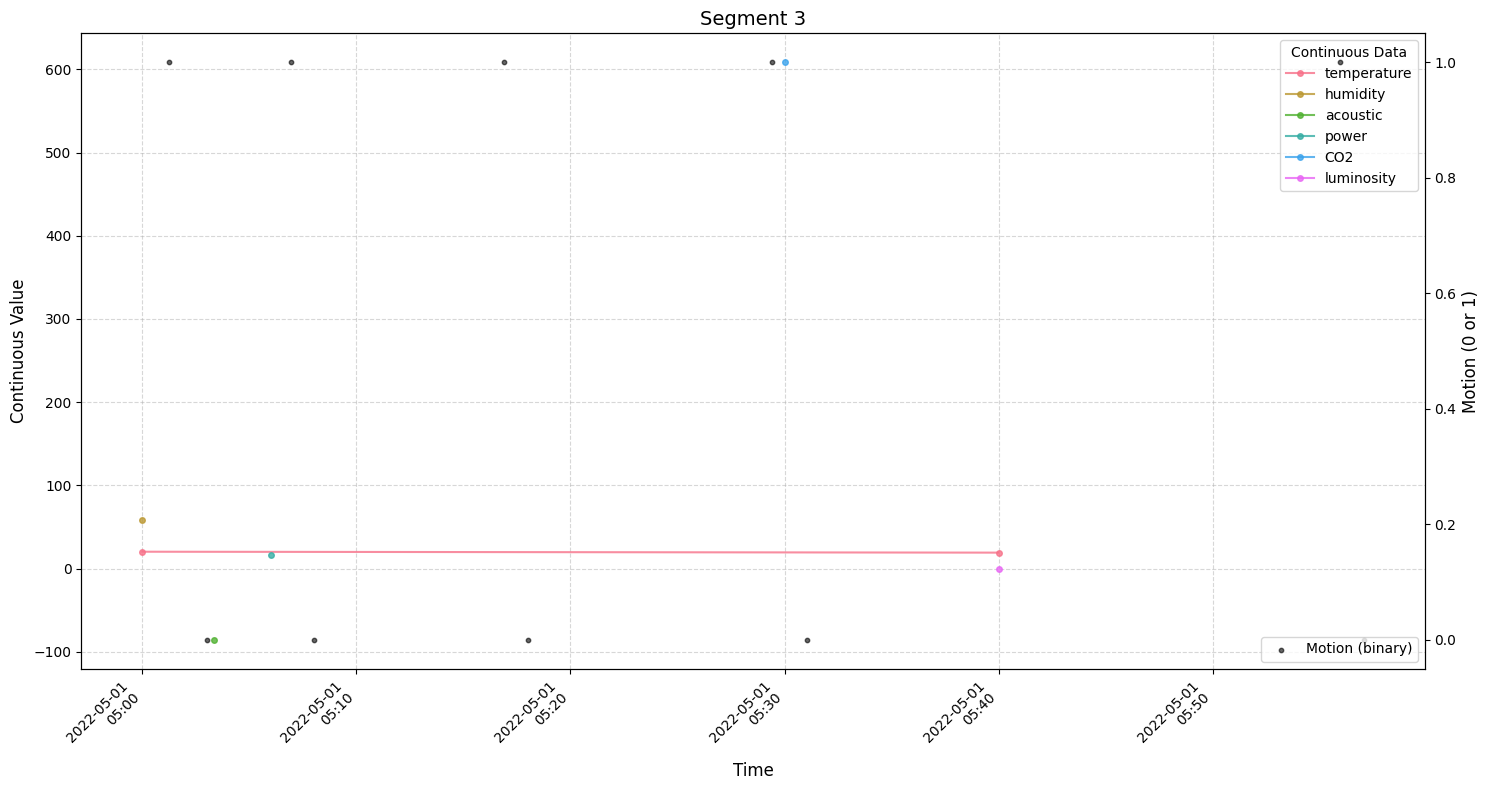

In [16]:
multi_lineplot(segmented_data[5], "Segment 3")

In [17]:
df_data = {"start_time": [], "end_time": []}
for datatype in datatypes:
    df_data[datatype] = []

In [18]:
for i in tqdm(range(len(timestamps) - 1)):
    start_time = timestamps[i]
    end_time = timestamps[i + 1]

    segment = segment_df[
        (segment_df["epochtime"] >= start_time) &
        (segment_df["epochtime"] < end_time)
    ]

    if segment.empty:
        df_data["start_time"].append(start_time)
        df_data["end_time"].append(end_time)
        for datatype in datatypes:
            df_data[datatype].append(pd.NA)
        continue

    df_data["start_time"].append(start_time)
    df_data["end_time"].append(end_time)
    
    for datatype in datatypes:
        data_rows = segment[segment["datatype"] == datatype]

        if segment.empty:
            df_data[datatype].append(pd.NA)
        
        if datatype not in {"motion", "contact"}:
            df_data[datatype].append(
                data_rows["value"].mean()
            )

        else:
            df_data[datatype].append(
                data_rows["value"].sum()
            )

100%|██████████| 8713/8713 [00:20<00:00, 422.95it/s]


In [19]:
expected_df = pd.DataFrame(df_data)
expected_df.head(10)

,start_time,end_time,motion,power,acoustic,CO2,luminosity,humidity,temperature,contact
0,2022-05-01 00:00:00,2022-05-01 01:00:00,0.0,12.395714,-86.333334,721.00,0.0,NaN,19.300,0.0
1,2022-05-01 01:00:00,2022-05-01 02:00:00,3.0,14.790000,-86.000000,704.50,0.0,59.860000,19.730,0.0
2,2022-05-01 02:00:00,2022-05-01 03:00:00,4.0,NaN,-87.166666,618.75,NaN,59.000000,20.500,0.0
3,2022-05-01 03:00:00,2022-05-01 04:00:00,2.0,14.770000,-86.666666,601.00,0.0,59.000000,19.800,0.0
4,2022-05-01 04:00:00,2022-05-01 05:00:00,3.0,2.478182,-86.666667,590.00,0.0,58.000000,19.950,0.0
5,2022-05-01 05:00:00,2022-05-01 06:00:00,5.0,16.295000,-85.666667,608.50,0.0,58.000000,19.850,0.0
6,2022-05-01 06:00:00,2022-05-01 07:00:00,3.0,34.857500,-85.875000,571.50,NaN,56.446667,20.400,1.0
7,2022-05-01 07:00:00,2022-05-01 08:00:00,2.0,0.005000,-87.333333,508.25,6.0,56.850000,19.535,0.0
8,2022-05-01 08:00:00,2022-05-01 09:00:00,3.0,NaN,-85.222222,521.80,7.0,57.000000,19.725,0.0
9,2022-05-01 09:00:00,2022-05-01 10:00:00,3.0,NaN,-85.000000,458.00,0.0,55.200000,19.620,0.0


In [20]:
# Check giá trị nan trong dữ liệu đơn lẻ nhiều chiều
expected_df.isna().sum()

start_time        0
end_time          0
motion            0
power            82
acoustic        207
CO2             753
luminosity     1592
humidity        673
temperature     139
contact           0
dtype: int64

# 3. Khôi phục dữ liệu

Khôi phục dữ liệu sử dụng `Interpolation` và một số quy định khác như:

- Đối với dữ liệu liên tục: sử dụng `Cubic Inperpolation`
- Đối với dữ liệu trigger:
    - `Motion`: Không có dữ liệu = Không có ai đi qua ==> 0
    - `Contact`: Không có dữ liệu = Dữ liệu không thay đổi ==> Dữ liệu trước đó

In [21]:
from scipy.interpolate import CubicSpline

In [22]:
def plot_interpolation(train, test, poly):
    x_train, y_train = train
    x_test, y_test = test

    x_train = x_train[:200:]
    y_train = y_train[:200:]
    x_test = np.array([x for x in x_test if x < x_train.max()])
    y_test = np.array([y_test[i] for i in range(len(x_test))])


    plt.figure(figsize=(20, 7))
    plt.scatter(x_train, y_train, color = "red", marker = ".")
    plt.scatter(x_test, y_test, color = "green", marker = ".")

    x_new = np.arange(start = x_train.min(), stop = x_train.max(), step = 1)
    y_new = poly(x_new)
    plt.plot(x_new, y_new, label="Interpolation", color="blue", linewidth=0.5)

    plt.title(f"{datatype} - Time index")
    plt.xlabel("Time index")
    plt.ylabel(f"{datatype}")
    plt.legend()
    plt.show()


def continous_interpolation(df, datatype, plot):
    c_df = df.copy()
    
    # notna for train, na for prediction
    na = df[(df[datatype].isna()) | (df[datatype].isnull())]
    not_na = df[(df[datatype].notna()) & (df[datatype].notnull())]

    # not na for train
    times = not_na["time_index"].to_numpy()
    value = not_na[datatype].to_numpy()

    cs = CubicSpline(times, value)

    # na for prediction
    na_times = na["time_index"].to_numpy()
    interpolated_value = cs(na_times)

    # update
    na_idx = na.index
    c_df.loc[na_idx, datatype] = interpolated_value

    if plot:
        plot_interpolation((times, value), (na_times, interpolated_value), cs)

    return c_df

def trigger_interpolation(df, datatype):
    c_df = df.copy()

    if datatype == "motion":
        c_df[datatype] = c_df[datatype].apply(lambda x: 0 if pd.isna(x) else x)
    
    return c_df        

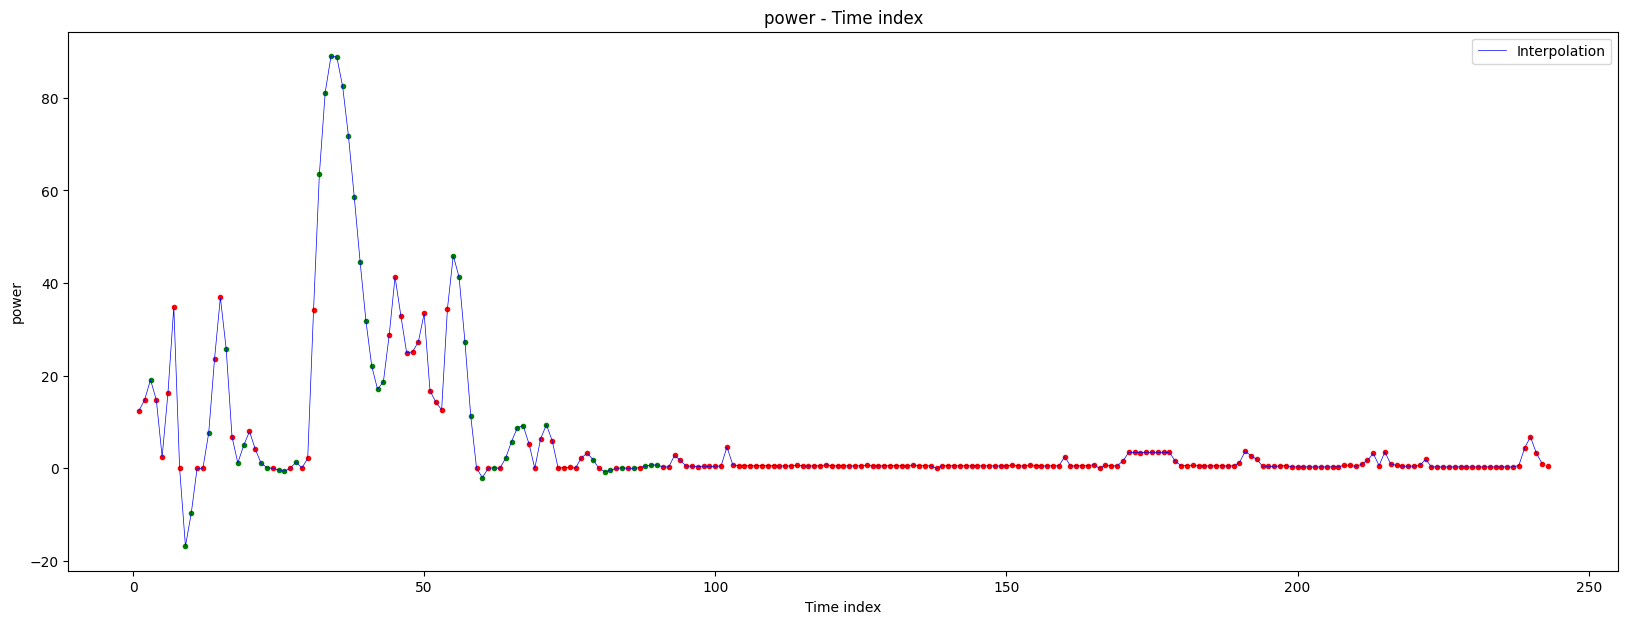

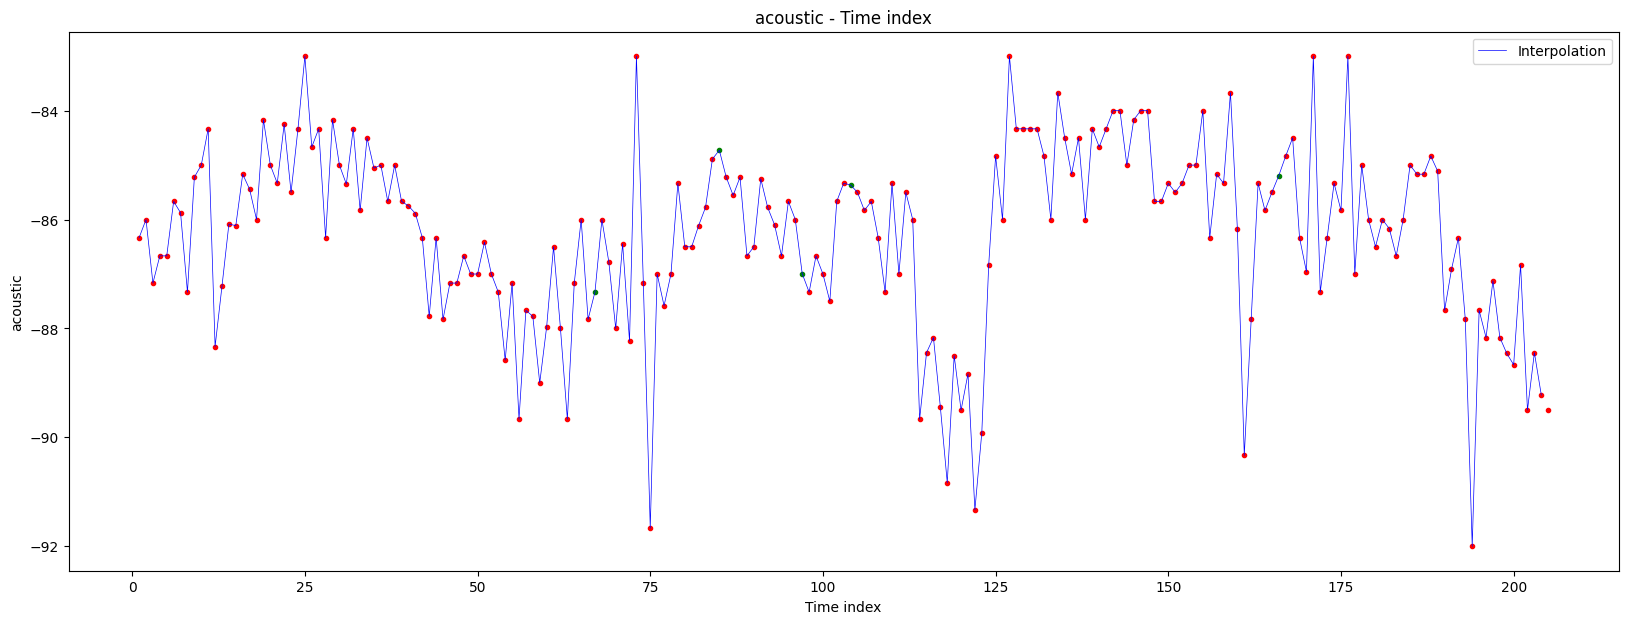

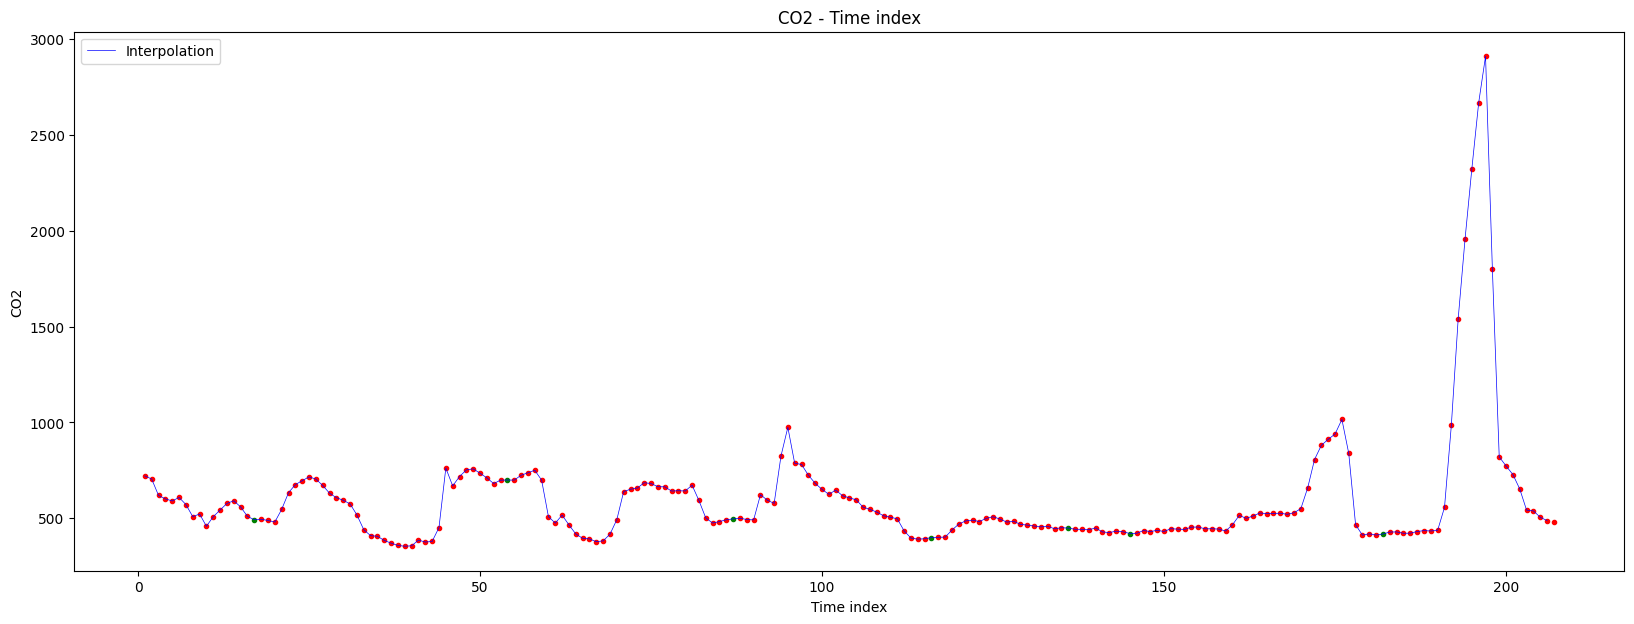

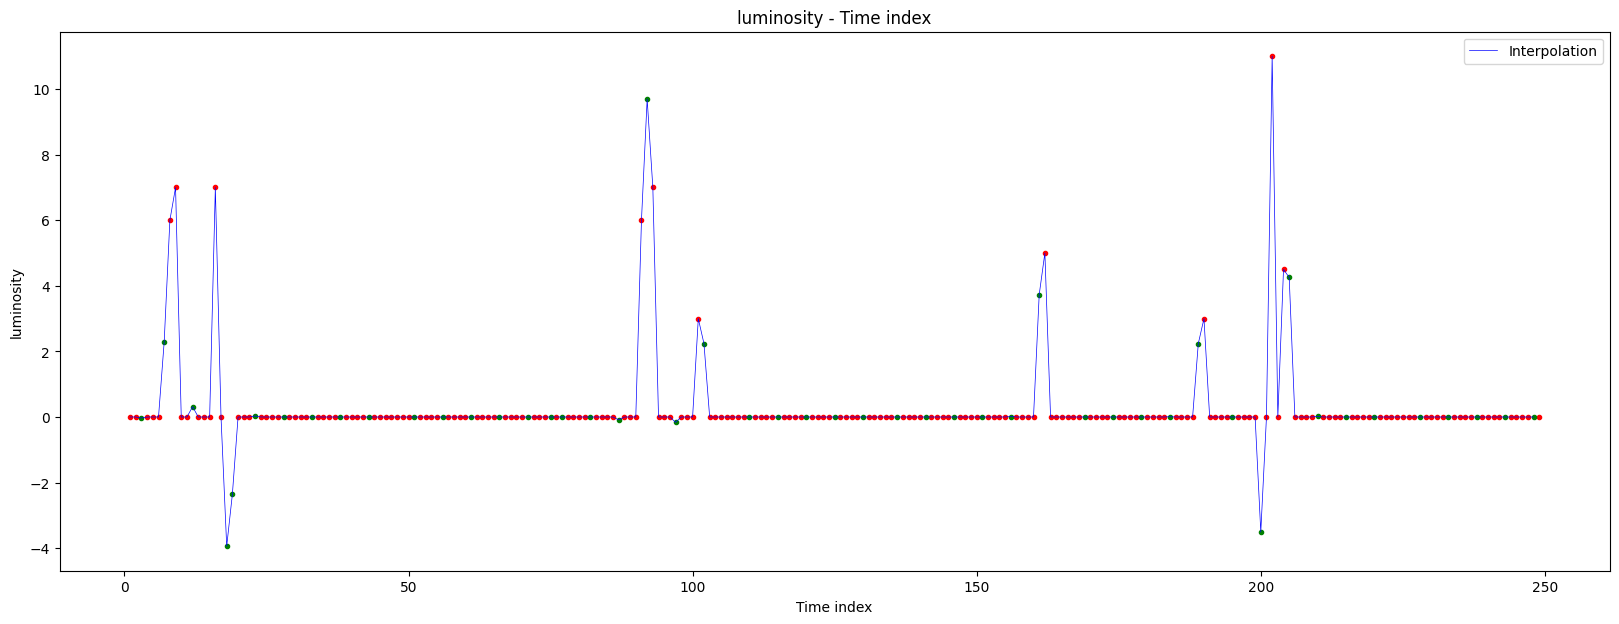

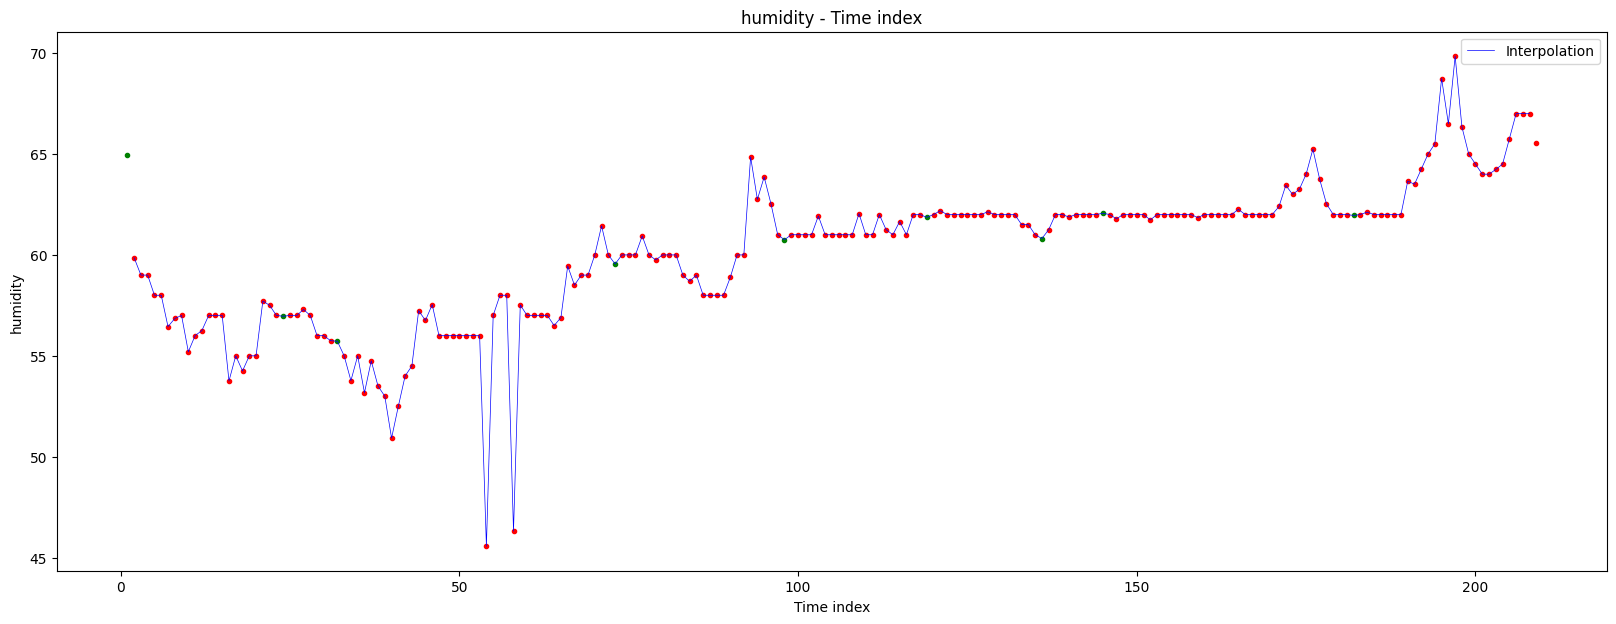

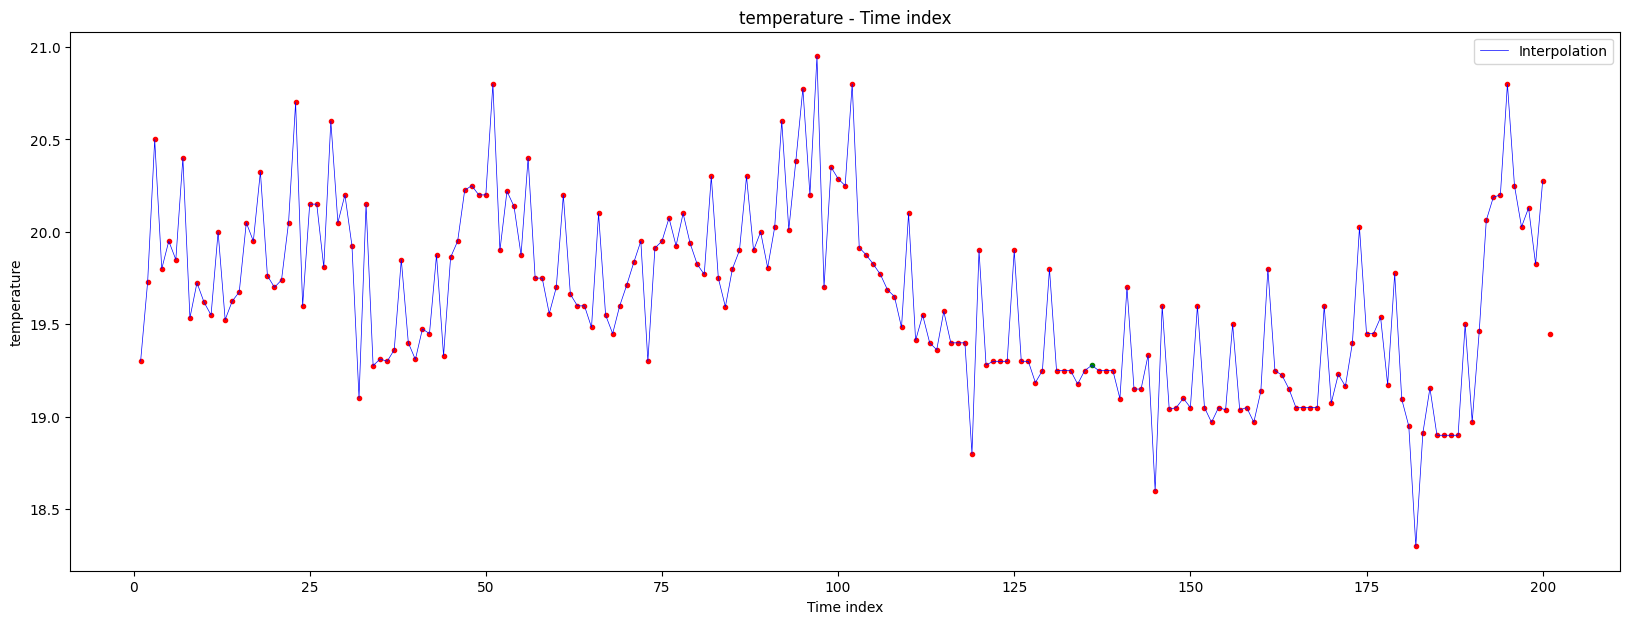

In [23]:
interpolated_df = expected_df.copy()

interpolated_df["time_index"] = pd.factorize(
    interpolated_df[["start_time", "end_time"]].astype(str).apply(lambda x: "_".join(x), axis = 1)
)[0] + 1


for datatype in datatypes:
    if datatype not in {"motion", "contact"}:
        interpolated_df = continous_interpolation(interpolated_df, datatype, True)
    else:
        if datatype == "motion":
            interpolated_df = trigger_interpolation(interpolated_df, datatype)

interpolated_df.drop(columns = ["time_index"], inplace = True)

In [24]:
expected_df.head(10)

,start_time,end_time,motion,power,acoustic,CO2,luminosity,humidity,temperature,contact
0,2022-05-01 00:00:00,2022-05-01 01:00:00,0.0,12.395714,-86.333334,721.00,0.0,NaN,19.300,0.0
1,2022-05-01 01:00:00,2022-05-01 02:00:00,3.0,14.790000,-86.000000,704.50,0.0,59.860000,19.730,0.0
2,2022-05-01 02:00:00,2022-05-01 03:00:00,4.0,NaN,-87.166666,618.75,NaN,59.000000,20.500,0.0
3,2022-05-01 03:00:00,2022-05-01 04:00:00,2.0,14.770000,-86.666666,601.00,0.0,59.000000,19.800,0.0
4,2022-05-01 04:00:00,2022-05-01 05:00:00,3.0,2.478182,-86.666667,590.00,0.0,58.000000,19.950,0.0
5,2022-05-01 05:00:00,2022-05-01 06:00:00,5.0,16.295000,-85.666667,608.50,0.0,58.000000,19.850,0.0
6,2022-05-01 06:00:00,2022-05-01 07:00:00,3.0,34.857500,-85.875000,571.50,NaN,56.446667,20.400,1.0
7,2022-05-01 07:00:00,2022-05-01 08:00:00,2.0,0.005000,-87.333333,508.25,6.0,56.850000,19.535,0.0
8,2022-05-01 08:00:00,2022-05-01 09:00:00,3.0,NaN,-85.222222,521.80,7.0,57.000000,19.725,0.0
9,2022-05-01 09:00:00,2022-05-01 10:00:00,3.0,NaN,-85.000000,458.00,0.0,55.200000,19.620,0.0


In [25]:
interpolated_df.head(10)

,start_time,end_time,motion,power,acoustic,CO2,luminosity,humidity,temperature,contact
0,2022-05-01 00:00:00,2022-05-01 01:00:00,0.0,12.395714,-86.333334,721.00,0.000000,64.944827,19.300,0.0
1,2022-05-01 01:00:00,2022-05-01 02:00:00,3.0,14.790000,-86.000000,704.50,0.000000,59.860000,19.730,0.0
2,2022-05-01 02:00:00,2022-05-01 03:00:00,4.0,19.133185,-87.166666,618.75,-0.030908,59.000000,20.500,0.0
3,2022-05-01 03:00:00,2022-05-01 04:00:00,2.0,14.770000,-86.666666,601.00,0.000000,59.000000,19.800,0.0
4,2022-05-01 04:00:00,2022-05-01 05:00:00,3.0,2.478182,-86.666667,590.00,0.000000,58.000000,19.950,0.0
5,2022-05-01 05:00:00,2022-05-01 06:00:00,5.0,16.295000,-85.666667,608.50,0.000000,58.000000,19.850,0.0
6,2022-05-01 06:00:00,2022-05-01 07:00:00,3.0,34.857500,-85.875000,571.50,2.295408,56.446667,20.400,1.0
7,2022-05-01 07:00:00,2022-05-01 08:00:00,2.0,0.005000,-87.333333,508.25,6.000000,56.850000,19.535,0.0
8,2022-05-01 08:00:00,2022-05-01 09:00:00,3.0,-16.820234,-85.222222,521.80,7.000000,57.000000,19.725,0.0
9,2022-05-01 09:00:00,2022-05-01 10:00:00,3.0,-9.709626,-85.000000,458.00,0.000000,55.200000,19.620,0.0


In [26]:
interpolated_df.to_excel("./process_data/parent bedroom.xlsx", index = False)